In [91]:
!pip install xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [92]:
data = pd.read_csv(r"D:\stock_data.csv")
data.head()

,Unnamed: 0,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
0,2020-01-01,101.764052,100.160928,99.494642,99.909756,101.761266
1,2020-01-02,102.171269,99.969968,98.682973,100.640755,102.528643
2,2020-01-03,103.171258,99.575237,98.182139,100.574847,101.887811
3,2020-01-04,105.483215,99.308641,97.149381,100.925017,101.490049
4,2020-01-05,107.453175,98.188428,99.575396,101.594411,101.604283


In [93]:
df = pd.DataFrame(data)
df.rename(columns = {'Unnamed: 0': 'date'}, inplace = True)
df.describe()

,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
count,365.000000,365.000000,365.000000,365.000000,365.000000
mean,107.772577,81.105216,94.519502,117.407560,106.866865
std,7.398296,11.435212,6.519213,6.778527,3.760968
min,91.474442,62.414219,81.111434,99.909756,99.833309
25%,101.603117,69.328263,89.788068,112.209912,103.927072
50%,107.421299,84.283525,94.495546,117.788079,106.411328
75%,113.741728,91.548859,99.919465,123.132365,109.178007
max,121.901773,100.160928,107.588373,129.911386,116.243803


In [94]:
df.isnull().sum()

date       0
Stock_1    0
Stock_2    0
Stock_3    0
Stock_4    0
Stock_5    0
dtype: int64

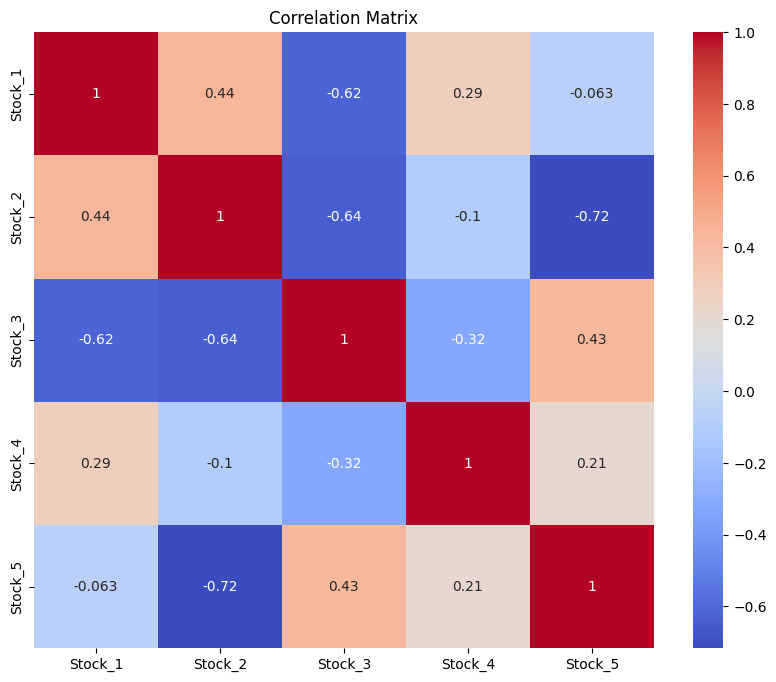

In [95]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Drop the date column for correlation calculation
data_for_corr = df.drop(columns=['date'])

# Calculate the correlation matrix
cormap = data_for_corr.corr()

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cormap, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation Matrix')
plt.show()


In [96]:
def get_corelated_col(cor_dat, threshold): 
  feature=[]
  value=[]

  for i ,index in enumerate(cor_dat.index):
    if abs(cor_dat[index]) > threshold:
      feature.append(index)
      value.append(cor_dat[index])

  df = pd.DataFrame(data = value, index = feature, columns=['corr value'])
  return df


In [97]:
top_corelated_values = get_corelated_col(cormap['Stock_2'], 0.60)
top_corelated_values

,corr value
Stock_2,1.000000
Stock_3,-0.644440
Stock_5,-0.716303


In [98]:
df.shape

(365, 6)

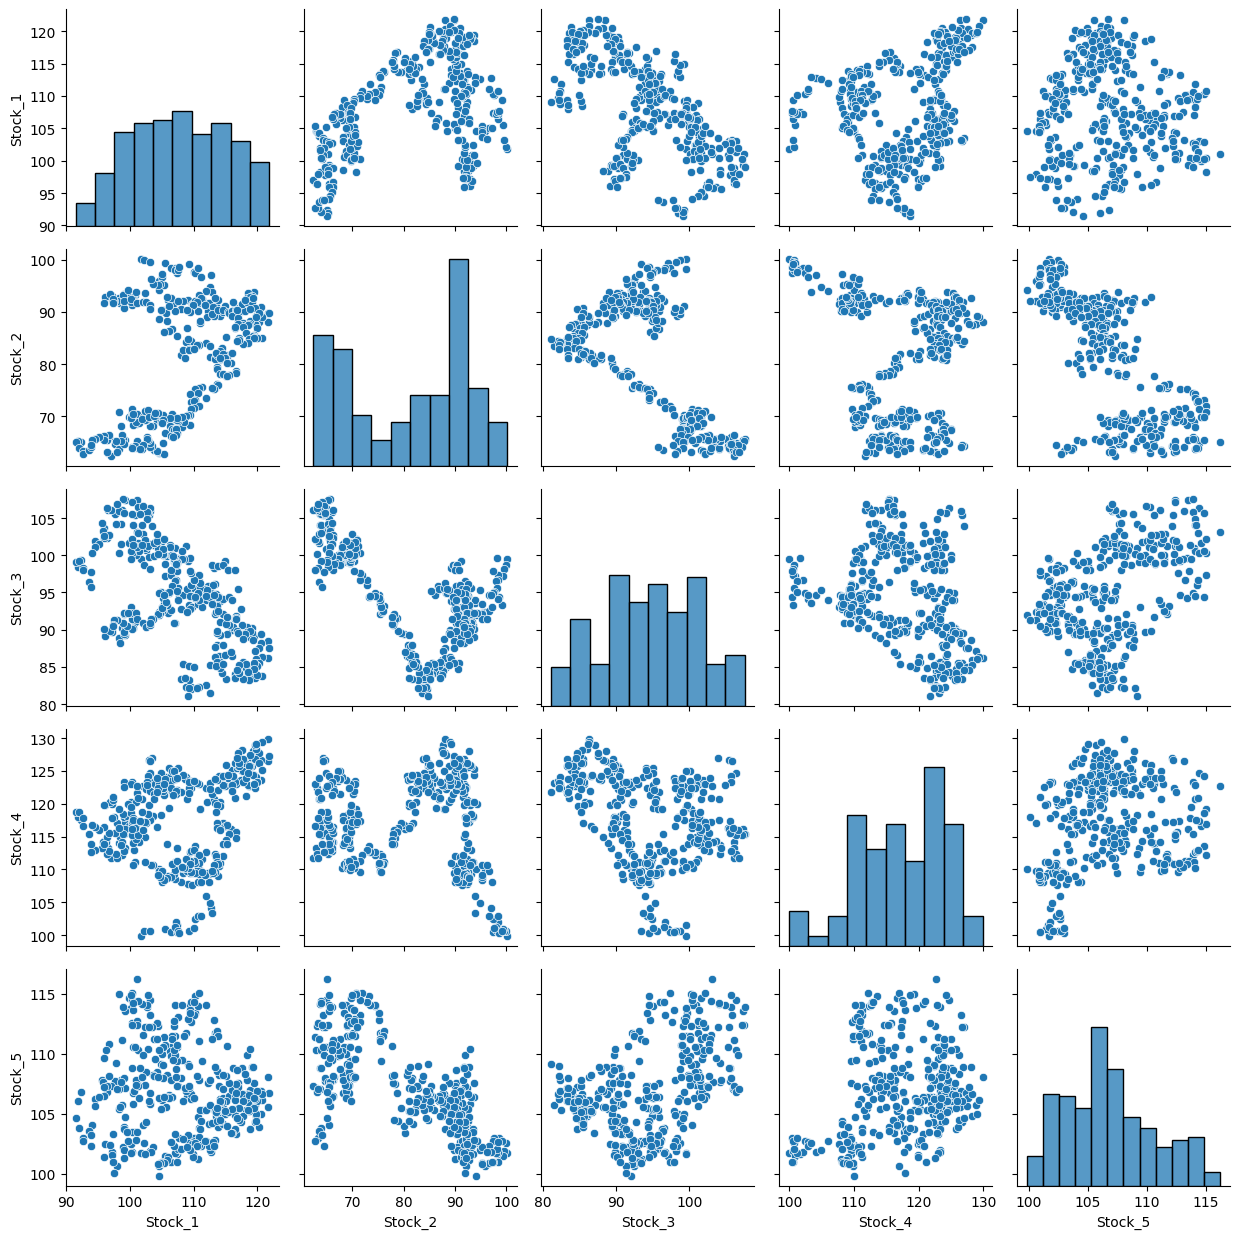

In [99]:
sns.pairplot(df)
plt.tight_layout()

In [100]:
X = df.drop(['Stock_2'], axis=1)
y = df['Stock_2']

In [101]:
X_numeric = X.select_dtypes(include=['number'])  # Select numeric columns only
# Scale the numeric features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)
X.head()

,date,Stock_1,Stock_3,Stock_4,Stock_5
0,2020-01-01,101.764052,99.494642,99.909756,101.761266
1,2020-01-02,102.171269,98.682973,100.640755,102.528643
2,2020-01-03,103.171258,98.182139,100.574847,101.887811
3,2020-01-04,105.483215,97.149381,100.925017,101.490049
4,2020-01-05,107.453175,99.575396,101.594411,101.604283


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, shuffle=True,random_state=42)

In [103]:
from sklearn.metrics import mean_squared_error



# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  
}

# Instantiate the KNN regressor
knn = KNeighborsRegressor()

# Instantiate the GridSearchCV object for KNN
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5)

# Fit the Grid Search object to your training data
grid_search_knn.fit(X_train, y_train)

# Use the best KNN estimator to make predictions
best_knn_model = grid_search_knn.best_estimator_
knn_predictions = best_knn_model.predict(X_test)

# Evaluate the KNN model performance using the evaluation metrics
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_rmse = knn_mse ** 0.5
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_r2 = r2_score(y_test, knn_predictions)

print("KNN Mean Squared Error:", knn_mse)
print("KNN Root Mean Squared Error:", knn_rmse)
print("KNN Mean Absolute Error:", knn_mae)
print("KNN R-squared Score:", knn_r2)

KNN Mean Squared Error: 1.220595206392523
KNN Root Mean Squared Error: 1.1048055061378554
KNN Mean Absolute Error: 0.8424122890306884
KNN R-squared Score: 0.9917297314021494


In [104]:
#!pip install xgboost
# XGBoost Regression Model with Grid Search
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9]
}
xgb_model = GridSearchCV(XGBRegressor(random_state=42), xgb_param_grid, cv=3, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_best_model = xgb_model.best_estimator_
xgb_predictions = xgb_best_model.predict(X_test)

xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = xgb_mse ** 0.5
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print("\nXGBoost Regression Metrics:")
print("Mean Squared Error:", xgb_mse)
print("Root Mean Squared Error:", xgb_rmse)
print("Mean Absolute Error:", xgb_mae)
print("R-squared Score:", xgb_r2)


XGBoost Regression Metrics:
Mean Squared Error: 4.337831668818255
Root Mean Squared Error: 2.082746184444532
Mean Absolute Error: 1.5678623219139265
R-squared Score: 0.9706085745335519


In [105]:
# Define the parameter grid for Grid Search
param_grid = {
    'fit_intercept': [True, False],
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid, cv=5)

# Fit the Grid Search object to your training data
grid_search.fit(X_train, y_train)
# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Evaluate the model performance using the evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)


Mean Squared Error: 37.79266382840624
Root Mean Squared Error: 6.147573816425976
Mean Absolute Error: 5.172938242928457
R-squared Score: 0.7439319118637584
